## Q1

In [1]:
import numpy
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
def tanh(x):
    return (1.0 - numpy.exp(-2*x))/(1.0 + numpy.exp(-2*x))

def tanh_derivative(x):
    return (1 + x)*(1 - x)

In [3]:
import numpy as np

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c = ListedColormap(('red', 'green'))(i), 
                    alpha=1.0,
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')

In [4]:
class NeuralNetwork:
    #########
    # parameters
    # ----------
    # self:      the class object itself
    # net_arch:  consists of a list of integers, indicating
    #            the number of neurons in each layer, i.e. the network architecture
    #########
    def __init__(self, net_arch):
        numpy.random.seed(0)
        
        # Initialized the weights, making sure we also 
        # initialize the weights for the biases that we will add later
        self.activity = tanh
        self.activity_derivative = tanh_derivative
        self.layers = len(net_arch)
        self.steps_per_epoch = 1
        self.arch = net_arch
        self.weights = []

        # Random initialization with range of weight values (-1,1)
        for layer in range(self.layers - 1):
            w = 2*numpy.random.rand(net_arch[layer] + 1, net_arch[layer+1]) - 1
            self.weights.append(w)
    
    def _forward_prop(self, x):
        y = x

        for i in range(len(self.weights)-1):
            activation = numpy.dot(y[i], self.weights[i])
            activity = self.activity(activation)

            # add the bias for the next layer
            activity = numpy.concatenate((numpy.ones(1), numpy.array(activity)))
            y.append(activity)

        # last layer
        activation = numpy.dot(y[-1], self.weights[-1])
        activity = self.activity(activation)
        y.append(activity)
        
        return y
    
    def _back_prop(self, y, target, learning_rate):
        error = target - y[-1]
        delta_vec = [error * self.activity_derivative(y[-1])]

        # we need to begin from the back, from the next to last layer
        for i in range(self.layers-2, 0, -1):
            error = delta_vec[-1].dot(self.weights[i][1:].T)
            error = error*self.activity_derivative(y[i][1:])
            delta_vec.append(error)

        # Now we need to set the values from back to front
        delta_vec.reverse()
        
        # Finally, we adjust the weights, using the backpropagation rules
        for i in range(len(self.weights)):
            layer = y[i].reshape(1, self.arch[i]+1)
            delta = delta_vec[i].reshape(1, self.arch[i+1])
            self.weights[i] += learning_rate*layer.T.dot(delta)
    
    #########
    # parameters
    # ----------
    # self:    the class object itself
    # data:    the set of all possible pairs of booleans True or False indicated by the integers 1 or 0
    # labels:  the result of the logical operation 'xor' on each of those input pairs
    #########
    def fit(self, data, labels, learning_rate=0.1, epochs=100):
        
        # Add bias units to the input layer - 
        # add a "1" to the input data (the always-on bias neuron)
        ones = numpy.ones((1, data.shape[0]))
        Z = numpy.concatenate((ones.T, data), axis=1)
        
        for k in range(epochs):
            if (k+1) % 10000 == 0:
                print('epochs: {}'.format(k+1))
        
            sample = numpy.random.randint(X.shape[0])

            # We will now go ahead and set up our feed-forward propagation:
            x = [Z[sample]]
            y = self._forward_prop(x)

            # Now we do our back-propagation of the error to adjust the weights:
            target = labels[sample]
            self._back_prop(y, target, learning_rate)
    
    #########
    # the predict function is used to check the prediction result of
    # this neural network.
    # 
    # parameters
    # ----------
    # self:   the class object itself
    # x:      single input data
    #########
    def predict_single_data(self, x):
        val = numpy.concatenate((numpy.ones(1).T, numpy.array(x)))
        for i in range(0, len(self.weights)):
            val = self.activity(numpy.dot(val, self.weights[i]))
            val = numpy.concatenate((numpy.ones(1).T, numpy.array(val)))
        return val[1]
    
    #########
    # the predict function is used to check the prediction result of
    # this neural network.
    # 
    # parameters
    # ----------
    # self:   the class object itself
    # X:      the input data array
    #########
    def predict(self, X):
        Y = numpy.array([]).reshape(0, self.arch[-1])
        for x in X:
            y = numpy.array([[self.predict_single_data(x)]])
            Y = numpy.vstack((Y,y))
        return Y

In [5]:
numpy.random.seed(0)

# Initialize the NeuralNetwork with
# 2 input neurons
# 2 hidden neurons
# 1 output neuron
nn = NeuralNetwork([2,2,1])

# Set the input data
X = numpy.array([[0, 0], [0, 1],
                [1, 0], [1, 1]])

# Set the labels, the correct results for the xor operation
y = numpy.array([0, 1, 
                 1, 0])

# Call the fit function and train the network for a chosen number of epochs
nn.fit(X, y, epochs=100000)

# Show the prediction results
print("Final prediction")
for s in X:
    print(s, nn.predict_single_data(s))


epochs: 10000
epochs: 20000
epochs: 30000
epochs: 40000
epochs: 50000
epochs: 60000
epochs: 70000
epochs: 80000
epochs: 90000
epochs: 100000
Final prediction
[0 0] 2.769390318381638e-05
[0 1] 0.9951542957694961
[1 0] 0.9951532983339083
[1 1] 2.783428053814478e-05


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


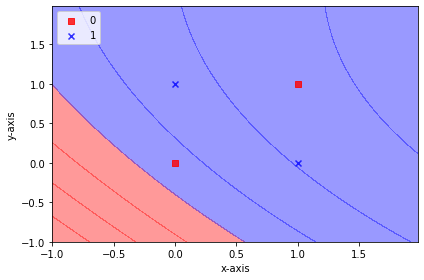

In [9]:
numpy.random.seed(0)
nn = NeuralNetwork([2,2,1])
nn.fit(X, y, epochs=10)
plot_decision_regions(X, y, nn)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show();

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


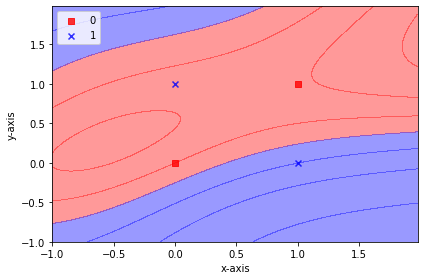

In [7]:
numpy.random.seed(0)
nn = NeuralNetwork([2,4,3,1])
nn.fit(X, y, epochs=10)
plot_decision_regions(X, y, nn)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


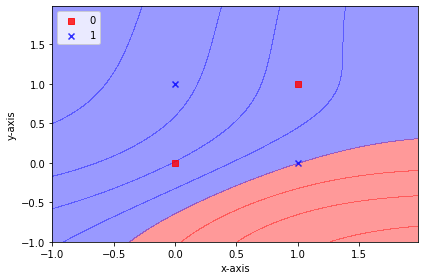

In [8]:
numpy.random.seed(0)
nn = NeuralNetwork([2,4,1])
nn.fit(X, y, epochs=10)
plot_decision_regions(X, y, nn)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Q2

In [10]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

In [11]:
# Importing the dataset
dataset = pd.read_csv('Social_Network_Ads.csv')
X = dataset.iloc[:, [2, 3]].values
y = dataset.iloc[:, 4].values

dataset.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

from sklearn.preprocessing import StandardScaler 
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

from sklearn.svm import SVC

classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [13]:
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear', max_iter=-1,

probability=False, random_state=0, shrinking=True, tol=0.001, verbose=False)

y_pred = classifier.predict(X_test)

from sklearn.metrics import confusion_matrix
result = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(result)

from sklearn.metrics import classification_report
result1 = classification_report(y_test, y_pred)
print("Classification Report:",)

print (result1)
from sklearn.metrics import accuracy_score
result2 = accuracy_score(y_test,y_pred)
print("Accuracy:",result2)

Confusion Matrix:
[[66  2]
 [ 8 24]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        68
           1       0.92      0.75      0.83        32

    accuracy                           0.90       100
   macro avg       0.91      0.86      0.88       100
weighted avg       0.90      0.90      0.90       100

Accuracy: 0.9


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


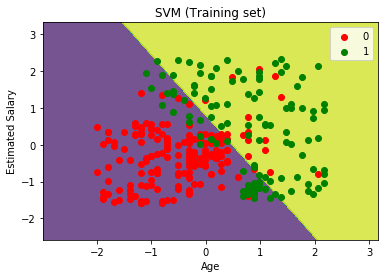

In [14]:
from matplotlib.colors import ListedColormap
X_set, y_set = X_train, y_train

X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01), np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01)) 
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape), alpha = 0.75)
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], c = ListedColormap(('red', 'green'))(i), label = j)

plt.title('SVM (Training set)')
plt.xlabel('Age')

plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


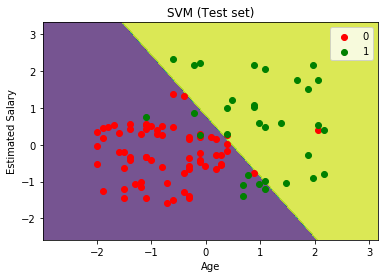

In [15]:
from matplotlib.colors import ListedColormap

X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01), np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))

plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),alpha = 0.75)

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], c = ListedColormap(('red', 'green'))(i), label = j)

plt.title('SVM (Test set)')

plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()